<br> </br>
<font size = 8> <center> AI Strategy and Digital transformation </center> </font>
<font size = 6> <center>  <b> 2. Cross-validation with KNN </b> </center>
<br>
<font size = 5> <center> Piotr Wójcik </center> </font>
<font size = 5> <center> University of Warsaw, Poland
<font size = 5> <center> pwojcik@wne.uw.edu.pl
<br> </br>
<font size = 5> <center>  January 2025 </center> </font>
</center> </font>

In [ ]:
# change working directory
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/szkolenia/2025-01_Bucharest'

Mounted at /content/drive
/content/drive/My Drive/szkolenia/2025-01_Bucharest


In [ ]:
# lets import all the needed packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score
from f_plot_roc_curve import *

In [8]:
# lets load the imputed churn data stored before
with open('outputs/churn_prepared.pkl', 'rb') as f:  # 'rb' stands for read in a binary mode
    churn_train_encoded = pickle.load(f)
    churn_test_encoded = pickle.load(f)

churn_test_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,average_utilization,customer_gender_M,customer_gender_Unknown,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_closed
2089,122823,-1.179263,0.490392,4.0,1.0,-1.875667,-0.460621,-0.047547,-0.341229,-0.402278,...,0.178986,0,0,0,1,0,0,0,0,1
8911,674482,0.824459,-0.276069,2.0,0.0,1.382108,-0.146121,-0.363695,-1.324011,-1.306320,...,-0.365464,0,0,1,0,0,0,0,0,0
8411,529000,0.824459,0.490392,4.0,3.0,0.880912,-0.094396,0.268601,0.641554,0.501764,...,-0.347316,1,0,0,1,0,0,0,0,0
7311,344732,-0.427867,0.490392,4.0,0.0,-0.372079,-0.429807,-0.363695,0.641554,-1.306320,...,1.826854,0,0,0,1,0,0,0,0,0
9211,957784,0.699226,-1.042530,2.0,3.0,1.131510,0.098896,-0.995992,2.607119,-1.306320,...,-0.223907,1,0,0,1,0,0,0,0,0


In [9]:
# application of KNN to predict the account_status
# WARNING! this model requires defining hyperparameters
# here only one k - the number of neighbors

# the good starting point is k = sqrt(n)

math.sqrt(len(churn_train_encoded))

84.19026071939675

In [11]:
# lets use 85 as the first odd number larger than sqrt(n)

# Split the data into features (X) and target (y)
# IMPORTANT! remember that customer ID is not a sensible predictor!

churn_train_X = churn_train_encoded.drop(['account_status_closed', 'customer_id'], axis = 1)
churn_train_y = churn_train_encoded['account_status_closed']

# IMPORTANT!
# remember that data are already scaled based on the training data distribution - otherwise we would need to scale it here for KNN

# Key Parameters of KNeighborsClassifier:
# - n_neighbors: The number of neighbors to use - the default value is 5.
# - weights: The weight function used in prediction:
#            'uniform' (all points in each neighborhood are weighted equally),
#            'distance' (weight points by the inverse of their distance), or a user-defined function.
# - p: Power parameter for the distance metric. When p=1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p=2. For arbitrary p, minkowski_distance (l_p) is used.

knn_churn = KNeighborsClassifier(n_neighbors = 85)
knn_churn.fit(churn_train_X, churn_train_y)

KNeighborsClassifier(n_neighbors=85)

In [12]:
# lets make predictions for the training data (in-sample)

predictions = knn_churn.predict(churn_train_X)

# Evaluate accuracy
print(f"Accuracy: {accuracy_score(churn_train_y, predictions)}")

# a more detailed summary for classification

print("Summary of predictions on the training data:")
print(classification_report(churn_train_y, predictions))

Accuracy: 0.8766930022573364
Summary of predictions on the training data:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      5949
           1       0.87      0.27      0.42      1139

    accuracy                           0.88      7088
   macro avg       0.87      0.63      0.67      7088
weighted avg       0.88      0.88      0.85      7088



In [13]:
# For the area under ROC curve we need the predicted probabilities, not only the classes

# Predict probabilities (for binary classification, shape is [n_samples, 2])
predictions_probs = knn_churn.predict_proba(churn_train_X)

# Extract the probability of the positive class, assume it’s at index 1
y_scores = predictions_probs[:, 1]

# Calculate the area under the ROC curve (AUROC)
roc_auc_score(churn_train_y, y_scores)

0.916548712047723

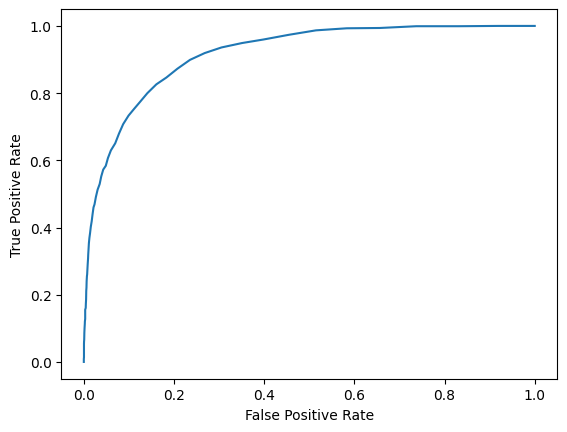

In [14]:
# Lets plot the ROC curve using the function from f_plot_roc_curve.py

plot_roc_curve(churn_train_y, y_scores)

In [16]:
# lets compare the same metrics for the test data

churn_test_X = churn_test_encoded.drop(['account_status_closed', 'customer_id'], axis = 1)
churn_test_y = churn_test_encoded['account_status_closed']

predictions_test = knn_churn.predict(churn_test_X)

# a more detailed summary for classification
print(classification_report(churn_test_y, predictions_test))

# comparable results

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2551
           1       0.90      0.27      0.41       488

    accuracy                           0.88      3039
   macro avg       0.89      0.63      0.67      3039
weighted avg       0.88      0.88      0.85      3039



In [17]:
# area under ROC curve for test data

# Predict probabilities (for binary classification, shape is [n_samples, 2])
predictions_probs_test = knn_churn.predict_proba(churn_test_X)

# Extract the probability of the positive class, assume it’s at index 1
y_scores_test = predictions_probs_test[:, 1]

# Calculate the area under the ROC curve (AUROC)
roc_auc_score(churn_test_y, y_scores_test)

0.9113880124155748

# Overfitting in KNN

In [18]:
# lets compare how the model for k = 1 to 99 performs on the train and test samples

# Define a range of odd k values from 1 to 99
k_values = list(range(1, 99))

# Prepare a list for collecting the performance rows
performance_rows = []

# the loop runs ca. 2 mimutes

for k in k_values:
    # Initialize KNN classifier with current k
    knn_i = KNeighborsClassifier(n_neighbors = k)
    # Fit the model on the training sample
    knn_i.fit(churn_train_X, churn_train_y)
    # Predict on the train and test sample
    y_pred_train = knn_i.predict(churn_train_X)
    y_pred_test = knn_i.predict(churn_test_X)

    # Get performance metrics as a dictionary
    c_report_train = classification_report(
        churn_train_y,
        y_pred_train,
        output_dict = True,
        zero_division = 0)  # to avoid division-by-zero errors

    c_report_test = classification_report(
        churn_test_y,
        y_pred_test,
        output_dict = True,
        zero_division = 0)  # to avoid division-by-zero errors

    row_train = {
        'k': k,
        'data': 'train',
        'accuracy': c_report_train['accuracy'],
        'precision_1': c_report_train['1']['precision'],
        'recall_1': c_report_train['1']['recall'],
        'f1_score_1': c_report_train['1']['f1-score'],
        'precision_0': c_report_train['0']['precision'],
        'recall_0': c_report_train['0']['recall'],
        'f1_score_0': c_report_train['0']['f1-score'],
        'macro_recall': c_report_train['macro avg']['recall'],
        'macro_precision': c_report_train['macro avg']['precision'],
        'macro_f1': c_report_train['macro avg']['f1-score']
    }

    row_test = {
        'k': k,
        'data': 'test',
        'accuracy': c_report_test['accuracy'],
        'precision_1': c_report_test['1']['precision'],
        'recall_1': c_report_test['1']['recall'],
        'f1_score_1': c_report_test['1']['f1-score'],
        'precision_0': c_report_test['0']['precision'],
        'recall_0': c_report_test['0']['recall'],
        'f1_score_0': c_report_test['0']['f1-score'],
        'macro_recall': c_report_test['macro avg']['recall'],
        'macro_precision': c_report_test['macro avg']['precision'],
        'macro_f1': c_report_test['macro avg']['f1-score']
    }
    # Append each row (for each k) to our performance list
    performance_rows.append(row_train)
    performance_rows.append(row_test)

# Convert list of dicts to a DataFrame
performance_df = pd.DataFrame(performance_rows)

In [19]:
# if you want to check the structure of the python object

from rich import inspect
inspect(c_report_train)

╭──────────────────────────── <class 'dict'> ────────────────────────────╮
│ dict() -> new empty dictionary                                         │
│ dict(mapping) -> new dictionary initialized from a mapping object's    │
│     (key, value) pairs                                                 │
│ dict(iterable) -> new dictionary initialized as if via:                │
│     d = {}                                                             │
│     for k, v in iterable:                                              │
│         d[k] = v                                                       │
│ dict(**kwargs) -> new dictionary initialized with the name=value pairs │
│     in the keyword argument list.  For example:  dict(one=1, two=2)    │
│                                                                        │
│ ╭────────────────────────────────────────────────────────────────────╮ │
│ │ {                                                                  │ │
│ │ │   '0': {                                                         │ │
│ │ │   │   'precision': 0.8753889465105942,                           │ │
│ │ │   │   'recall': 0.993108085392503,                               │ │
│ │ │   │   'f1-score': 0.9305402425578831,                            │ │
│ │ │   │   'support': 5949.0                                          │ │
│ │ │   },                                                             │ │
│ │ │   '1': {                                                         │ │
│ │ │   │   'precision': 0.8790560471976401,                           │ │
│ │ │   │   'recall': 0.26163301141352063,                             │ │
│ │ │   │   'f1-score': 0.40324763193504737,                           │ │
│ │ │   │   'support': 1139.0                                          │ │
│ │ │   },                                                             │ │
│ │ │   'accuracy': 0.8755643340857788,                                │ │
│ │ │   'macro avg': {                                                 │ │
│ │ │   │   'precision': 0.8772224968541171,                           │ │
│ │ │   │   'recall': 0.6273705484030118,                              │ │
│ │ │   │   'f1-score': 0.6668939372464653,                            │ │
│ │ │   │   'support': 7088.0                                          │ │
│ │ │   },                                                             │ │
│ │ │   'weighted avg': {                                              │ │
│ │ │   │   'precision': 0.8759782280685153,                           │ │
│ │ │   │   'recall': 0.8755643340857788,                              │ │
│ │ │   │   'f1-score': 0.8458074147504043,                            │ │
│ │ │   │   'support': 7088.0                                          │ │
│ │ │   }                                                              │ │
│ │ }                                                                  │ │
│ ╰────────────────────────────────────────────────────────────────────╯ │
│                                                                        │
│ 35 attribute(s) not shown. Run inspect(inspect) for options.           │
╰────────────────────────────────────────────────────────────────────────╯

In [20]:
# check the first few rows of the result
performance_df.head(10)

,k,data,accuracy,precision_1,recall_1,f1_score_1,precision_0,recall_0,f1_score_0,macro_recall,macro_precision,macro_f1
0,1,train,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,test,0.858177,0.563474,0.518443,0.540021,0.909266,0.923167,0.916164,0.720805,0.736370,0.728093
2,2,train,0.924802,1.000000,0.532046,0.694556,0.917772,1.000000,0.957123,0.766023,0.958886,0.825840
3,2,test,0.874959,0.772727,0.313525,0.446064,0.882084,0.982360,0.929525,0.647942,0.827406,0.687795
4,3,train,0.935948,0.879291,0.697103,0.777669,0.944220,0.981678,0.962584,0.839390,0.911756,0.870127
5,3,test,0.891083,0.741538,0.493852,0.592866,0.908990,0.967072,0.937132,0.730462,0.825264,0.764999
6,4,train,0.915632,0.938412,0.508341,0.659453,0.913460,0.993612,0.951852,0.750977,0.925936,0.805653
7,4,test,0.884501,0.830918,0.352459,0.494964,0.888418,0.986280,0.934795,0.669369,0.859668,0.714879
8,5,train,0.920993,0.860523,0.606673,0.711637,0.928719,0.981173,0.954226,0.793923,0.894621,0.832932
9,5,test,0.891741,0.767677,0.467213,0.580892,0.905179,0.972952,0.937842,0.720082,0.836428,0.759367


<Axes: xlabel='k', ylabel='accuracy'>

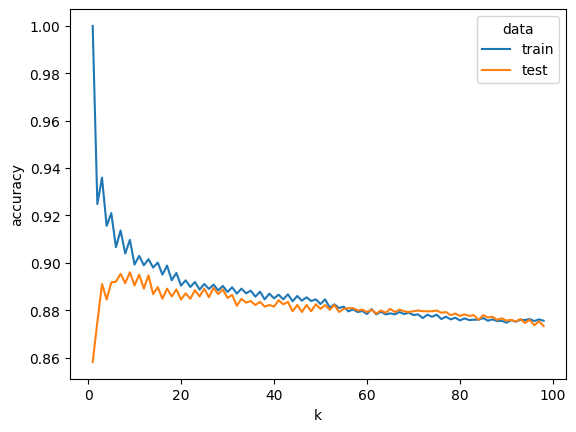

In [21]:
# We can plot the results showing a clear overfitting for small values of k
sns.lineplot(data = performance_df, x = 'k', y = 'accuracy', hue = 'data')

<Axes: xlabel='k', ylabel='macro_recall'>

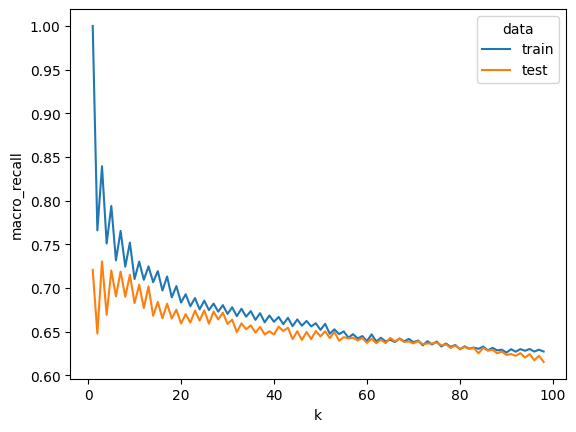

In [22]:
# lets check balanced accuracy (macro_recall)
sns.lineplot(data = performance_df, x = 'k', y = 'macro_recall', hue = 'data')

One can clearly see the problem of overfitting for a small number of neighbors (the most flexible model)

# Hyperparameter tuning

In [23]:
# Define a range of k values
# just odd numbers from 1 to 99 every 2
k_values = list(range(1, 99, 2))

# Initialize lists to store mean accuracy scores
mean_accuracy_scores = []

# Iterate over each k value
for k in k_values:
    # Initialize KNN classifier with current k value
    knn_i = KNeighborsClassifier(n_neighbors = k)
    # Perform 5-fold cross-validation with a fixed random state for each k
    k_folds = KFold(n_splits = 5, # KFold allows for controlling the random state
                    shuffle = True, # Whether to shuffle the data before splitting
                    random_state = 123) # When shuffle is True, random_state affects the ordering of the indices

    # apply modelling and get the value of the metric
    scores = cross_val_score(knn_i,
                             churn_train_X,
                             churn_train_y,
                             cv = k_folds, # above defined 5-fold cross_validation
                             scoring = 'accuracy') # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    # Calculate mean accuracy score
    mean_accuracy = np.mean(scores)
    # Append mean accuracy to list
    mean_accuracy_scores.append(mean_accuracy)

# Find optimal k value with highest mean accuracy
optimal_k = k_values[np.argmax(mean_accuracy_scores)]
print("Optimal k value:", optimal_k)

# here ca. 40 seconds

Optimal k value: 7


Text(0, 0.5, 'Accuracy Score')

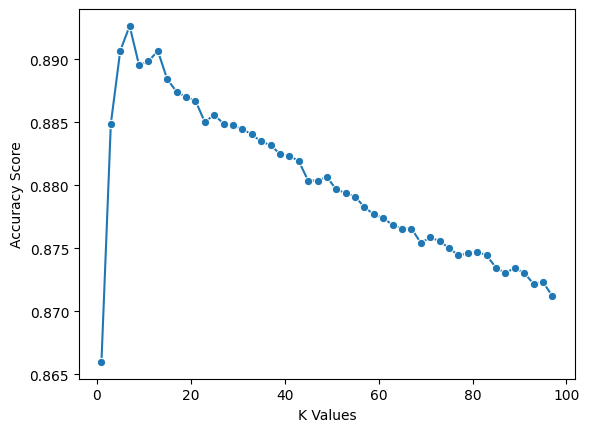

In [24]:
# We can plot the results of cross-validation
sns.lineplot(x = k_values,
             y = mean_accuracy_scores,
             marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

one can see the **reversed U shape** where accuracy in the validation sample initially increases with 'k' but then there is a turning point and it starts to decrease again

Optimal k value: 1


Text(0, 0.5, 'Balanced accuracy Score')

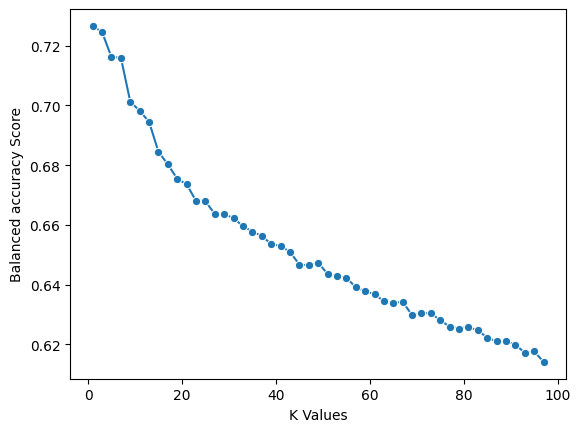

In [25]:
# lets check the same for another performance metric - e.g. balanced accuracy

k_values = list(range(1, 99, 2))

# Initialize lists to store mean accuracy scores
mean_accuracy_scores = []

# cross validation can be defined outside teh loop

# Perform 5-fold cross-validation with a fixed random state for each k
cv5 = KFold(n_splits = 5, # KFold allows for controlling the random state
            shuffle = True,
            random_state = 123) # The SAME as before

# Iterate over each k value
for k in k_values:
    # Initialize KNN classifier with current k value
    knn_i = KNeighborsClassifier(n_neighbors = k)

    # apply modelling and get the value of the metric
    scores = cross_val_score(knn_i,
                             churn_train_X,
                             churn_train_y,
                             cv = cv5,
                             scoring = 'balanced_accuracy') # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    # Calculate mean accuracy score
    mean_accuracy = np.mean(scores)
    # Append mean accuracy to list
    mean_accuracy_scores.append(mean_accuracy)

# Find optimal k value with highest mean accuracy
optimal_k = k_values[np.argmax(mean_accuracy_scores)]
print("Optimal k value:", optimal_k)

# We can plot the results of cross-validation
sns.lineplot(x = k_values,
             y = mean_accuracy_scores,
             marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Balanced accuracy Score")

# so balanced accuracy is also not always the best metric to optimize...

Optimal k value: 27


Text(0, 0.5, 'AUC Score')

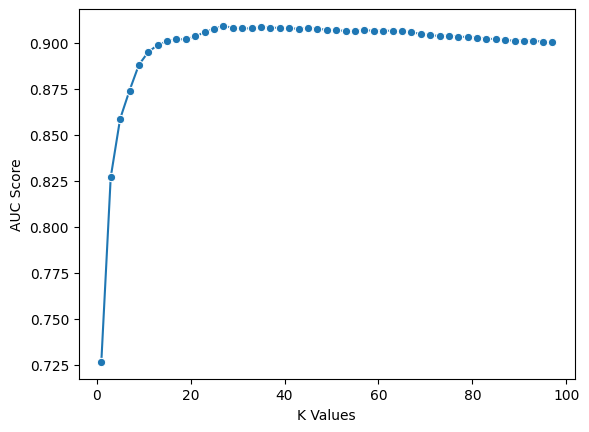

In [26]:
# lets check the same for one more performance metric - e.g. AUROC

k_values = list(range(1, 99, 2))

# Initialize lists to store mean accuracy scores
mean_accuracy_scores = []

# Perform 5-fold cross-validation with a fixed random state for each k
cv5 = KFold(n_splits = 5, # KFold allows for controlling the random state
            shuffle = True,
            random_state = 123) # The SAME as before

# Iterate over each k value
for k in k_values:
    # Initialize KNN classifier with current k value
    knn_i = KNeighborsClassifier(n_neighbors = k)

    # apply modelling and get the value of the metric
    scores = cross_val_score(knn_i,
                             churn_train_X,
                             churn_train_y,
                             cv = cv5, # 5-fold cross_validation
                             scoring = 'roc_auc') # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    # Calculate mean accuracy score
    mean_accuracy = np.mean(scores)
    # Append mean accuracy to list
    mean_accuracy_scores.append(mean_accuracy)

# Find optimal k value with highest mean accuracy
optimal_k = k_values[np.argmax(mean_accuracy_scores)]
print("Optimal k value:", optimal_k)

# We can plot the results of cross-validation
sns.lineplot(x = k_values,
             y = mean_accuracy_scores,
             marker = 'o')
plt.xlabel("K Values")
plt.ylabel("AUC Score")

In [27]:
# We can now train our model using the best k value (based on AUROC)

best_index = np.argmax(mean_accuracy_scores)
best_k = k_values[best_index]
churn_knn_best = KNeighborsClassifier(n_neighbors = best_k)
churn_knn_best.fit(churn_train_X,
                   churn_train_y)


KNeighborsClassifier(n_neighbors=27)

In [28]:
# what is the value of the AUROC metric for this model based on cross-validation?

print(mean_accuracy_scores[best_index])


0.9090641539818473


In [29]:
# then evaluate it on the test data to check if the value obtained in cross-validation
# is a good prediction of the performance on test data

predictions_test_best = churn_knn_best.predict(churn_test_X)

# a more detailed summary for classification
print(classification_report(churn_test_y, predictions_test_best))

# area under ROC curve for test data

# Predict probabilities (for binary classification, shape is [n_samples, 2])
predictions_probs_test_best = churn_knn_best.predict_proba(churn_test_X)

# Extract the probability of the positive class, assume it’s at index 1
y_scores_test_best = predictions_probs_test_best[:, 1]

# Calculate the area under the ROC curve (AUROC)
roc_auc_score(churn_test_y, y_scores_test_best)


              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2551
           1       0.89      0.35      0.51       488

    accuracy                           0.89      3039
   macro avg       0.89      0.67      0.72      3039
weighted avg       0.89      0.89      0.87      3039



0.9114410292331518

Looks like AUC obtained based on CV is a very good proxy of performance on the test sample (without looking in the test sample)!

In [30]:
# the results for k=85 once again for comparison
print(classification_report(churn_test_y, predictions_test))

roc_auc_score(churn_test_y, y_scores_test)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2551
           1       0.90      0.27      0.41       488

    accuracy                           0.88      3039
   macro avg       0.89      0.63      0.67      3039
weighted avg       0.88      0.88      0.85      3039



0.9113880124155748

In [31]:
# lets store the best KNN model for further analyses
with open("outputs/model_churn_knn_best.pkl", 'wb') as file:
    pickle.dump(churn_knn_best, file)


# Exercises 2

## Exercise 2.1

Check what is the optimal KNN model for `churn` dataset for churn data based on f1 score or average_precision

In [ ]:
# place for solution to Exercise 2.1

## Exercise 2.2

Use a different standardization (scaling) of the data - range instead of z-scores (Min-Max scaler transforms a feature into the range [0,1]) and check the optimal number of neighbors for churn data based on Accuracy, AUROC, and BA - do the conclusions differ from the model based on z-scores?

In [ ]:
# place for solution to Exercise 2.2

## Exercise 2.3

Extract the best model based on the AUROC metric and range scaled data and check its performance on the test set. It better than the best model based on z-scores?

In [ ]:
# place for solution to Exercise 2.3

## Exercise 2.4

Estimate the KNN model based on the houses dataset:

* use k = sqrt(n)
* find optimal value of k and store the best model for further analyses

In [ ]:
# place for solution to Exercise 2.4